In [3]:
import torch
from torch.cuda.amp import autocast,GradScaler
import torchaudio
import models
from torch import nn
import matplotlib.pyplot as plt

/kuacc/users/bbiner21/.local/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = './exp/test-custom-f10-t10-impTrue-aspTrue-b48-lr1e-5-21-nocallTrue/fold1/models/best_audio_model.pth'
sd = torch.load(path, map_location=device)

for param_tensor in sd:
    print(param_tensor, "\t",sd[param_tensor].size())

module.v.cls_token 	 torch.Size([1, 1, 768])
module.v.pos_embed 	 torch.Size([1, 602, 768])
module.v.dist_token 	 torch.Size([1, 1, 768])
module.v.patch_embed.proj.weight 	 torch.Size([768, 1, 16, 16])
module.v.patch_embed.proj.bias 	 torch.Size([768])
module.v.blocks.0.norm1.weight 	 torch.Size([768])
module.v.blocks.0.norm1.bias 	 torch.Size([768])
module.v.blocks.0.attn.qkv.weight 	 torch.Size([2304, 768])
module.v.blocks.0.attn.qkv.bias 	 torch.Size([2304])
module.v.blocks.0.attn.proj.weight 	 torch.Size([768, 768])
module.v.blocks.0.attn.proj.bias 	 torch.Size([768])
module.v.blocks.0.norm2.weight 	 torch.Size([768])
module.v.blocks.0.norm2.bias 	 torch.Size([768])
module.v.blocks.0.mlp.fc1.weight 	 torch.Size([3072, 768])
module.v.blocks.0.mlp.fc1.bias 	 torch.Size([3072])
module.v.blocks.0.mlp.fc2.weight 	 torch.Size([768, 3072])
module.v.blocks.0.mlp.fc2.bias 	 torch.Size([768])
module.v.blocks.1.norm1.weight 	 torch.Size([768])
module.v.blocks.1.norm1.bias 	 torch.Size([768])


In [4]:
# audio_model = models.ASTModel(label_dim=21, fstride=10, tstride=10, input_fdim=128,
#                                   input_tdim=512, imagenet_pretrain=True,
#                                   audioset_pretrain=True, model_size='base384')

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# path = '../egs/custom/exp/test-custom-f10-t10-impTrue-aspTrue-b48-lr1e-5-21-nocallTrue/fold1/models/best_audio_model.pth'
# sd = torch.load(path, map_location=device)

# if not isinstance(audio_model, nn.DataParallel):
#     audio_model = nn.DataParallel(audio_model)
# audio_model = audio_model.to(device)
# audio_model.load_state_dict(sd,strict=False)

# for tensor in audio_model.state_dict():
#     print(tensor)


# for param_tensor in sd:
#     print(param_tensor, "\t",sd[param_tensor].size())

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=600


_IncompatibleKeys(missing_keys=['module.new_layer.0.weight', 'module.new_layer.0.bias', 'module.new_layer.1.weight', 'module.new_layer.1.bias'], unexpected_keys=['module.mlp_head.0.weight', 'module.mlp_head.0.bias', 'module.mlp_head.1.weight', 'module.mlp_head.1.bias'])

32000


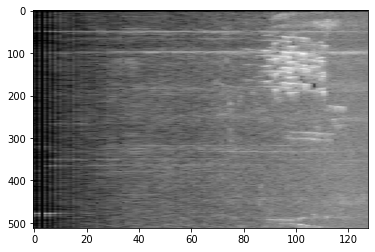

In [4]:
filename = '../egs/custom/birdclef_temp_data/aniani/XC27338.ogg'
waveform, sr = torchaudio.load(filename)

print(sr)

transform = torchaudio.transforms.Resample(sr, 16000)
waveform = transform(waveform)

fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=16000, use_energy=False, window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)


#fbank = torch.rot90(fbank, 3, [0, 1])
#fbank = torch.flip(fbank.t(), [0])
fbank = fbank[0:512,:]
plt.figure()
#plt.plot(fbank.t().numpy())
plt.imshow(fbank.numpy(), cmap='gray',aspect='auto')#,extent=[0,1400,0,128]

fbank = fbank.unsqueeze(0)

In [5]:
audio_model = models.ASTModel(label_dim=21, fstride=10, tstride=10, input_fdim=128,
                                  input_tdim=512, imagenet_pretrain=True,
                                  audioset_pretrain=True, model_size='base384')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = '../egs/custom/exp/test-custom-f10-t10-impTrue-aspTrue-b48-lr1e-5-22-bc_small_data-run2/models/audio_model.20.pth'

sd = torch.load(path, map_location=device)

if not isinstance(audio_model, nn.DataParallel):
    audio_model = nn.DataParallel(audio_model)
audio_model = audio_model.to(device)
audio_model.load_state_dict(sd,strict=False)

audio_model.eval();

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=600


In [6]:
fbank.shape

torch.Size([1, 512, 128])

In [7]:
out = audio_model(fbank)

In [8]:
out = torch.sigmoid(out)

In [9]:
out.shape

torch.Size([1, 21])